# Model-Agnostic Meta-Learning (MAML)
### Purpose
This notebook is meant to be the first of two, Tensorflow 2.0 reproductions of the MAML paper's simple regression and classification examples, with this one focusing on the **regression** task.
- MAML research paper: https://arxiv.org/abs/1703.03400
- Authors' blog post: https://bair.berkeley.edu/blog/2017/07/18/learning-to-learn/  

This notebook was modelled after and inspired by a similar notebook implementation, that specifically helped me to understand the "gradient through a gradient" implementation in Tensorflow 2.0.
- https://github.com/mari-linhares/tensorflow-maml

Things are done a bit differently in this notebook and I try to elaborate a bit on some of the challenges I faced reproducing the paper's results, despite having an implementation reference.

### The MAML algorithm
The MAML algorithm and meta-learning principle in generel, is explained in great detail in the research paper and blog listed above.  
I will simply give a short description.  

The goal is to arrive at a set weights for a neural network, which with only a few steps, can adapt to a new task. With the constraints that the new task is similar to the training tasks AND that a task only consists of a few (K) examples - also known as few-shot learning.  
In this regression case, we want to train a network on a lot of different sine wave functions - varying the amplitude and phase values - based on only K (usually 10) datapoints sampled randomly from each sine wave.  
In the test phase, K datapoints are sampled from new sine waves (not seen before combinations of amplitude and phase), and the network is only allowed to fit to the new data with a few gradient steps.

This is something that networks trained in the usual manner, struggle to do well.




## Imports and installs

In [0]:
!pip install -q tensorflow-gpu==2.0.0-rc

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

import time
import itertools
import math

Access local gdrive. Only needed for saving/loading trained model

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
path_root = '/content/gdrive/My Drive/Colab Notebooks/speciale/'
# names for saving and loading models
baseline_name = "baseline_regression_weights_K10_9000train.h5"
maml_name = "maml_regression_weights_K10_9000train.h5"


## Create dataset
In the generel terminology of the paper, the dataset consists of tasks, with each task containing a sine-wave function, that can be sampled for K datapoints. Sine waves vary in amplitude and phase, which are sampled in the following ranges:
- amplitude: 0.1 - 5.0
- phase: 0.0 - $\pi$
- the K samples (x values): -5.0 - 5.0

The TaskGenerator generates tasks (unsurprisingly), with each task having a fixed amplitude and phase value.

In [0]:
class TaskGenerator():
    def __init__(self, k_shot, amplitude=None, phase=None):
        self.K =  k_shot
        self.sample_range = (-5.0, 5.0)
        
        # set amplitude and phase to specified values OR choose randomly
        self.amplitude = amplitude if amplitude is not None else np.random.uniform(0.1, 5.0)
        self.phase = phase if phase is not None else np.random.uniform(0.0, np.pi)

    def sine(self, x, amplitude=None, phase=None):
        """Sine wave"""
        amplitude = amplitude if amplitude else self.amplitude
        phase = phase if phase else self.phase
        return amplitude * np.sin((x + phase))
    
    def _add_batch_dim(self, x, y):
        """ Adds a batch dimension, needed by the model """ 
        return x.reshape((-1,1)), y.reshape((-1,1))

    def sample_linspace(self, N=100):
        start, stop = self.sample_range
        x = np.linspace(start, stop, num=N)
        y = self.sine(x)
        x = x.astype(np.float32)
        y = y.astype(np.float32)
        return self._add_batch_dim(x,y)
    
    def sample(self, sort=False):
        start, stop = self.sample_range
        x = np.random.uniform(start, stop, size=self.K)
        if sort:
            # convenience for plotting with points in ascending order
            x = np.sort(x) 
        y = self.sine(x)
        x = x.astype(np.float32)
        y = y.astype(np.float32)
        return self._add_batch_dim(x,y)


Example of 3 different tasks, with sine waves and K samples from each.

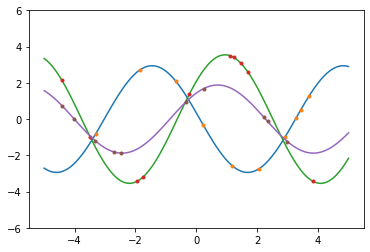

In [0]:
for _ in range(3):
    task = TaskGenerator(k_shot=10)
    x, y = task.sample(sort=False)
    x_full, y_full = task.sample_linspace()
    plt.plot(x_full, y_full, '-')
    plt.plot(x, y, '.')

plt.ylim(-6,6)
plt.show()

A total of 10.000 different sine waves are created (100 amplitude and phase values). They are shuffled and split into a train and test set, ensuring the test set consists of waves not present in the training set.

In [0]:
class Dataset():
    def __init__(self, data):
        self.data = data
    
    def size(self):
        return len(self.data)
    
    def batch(self, batch_size):
        assert batch_size > 0 and batch_size <= len(self.data), "Weird batch_size!"
        
        # shuffle data and pick batch_size from beginning
        np.random.shuffle(self.data)
        return self.data[: batch_size]
    

In [0]:
def create_train_test_datasets(K=10, N=100, test_size_percent=0.1):
    # sample N points in amplitude and phase ranges
    a_vals = np.around( np.linspace(0.1, 5.0, num=N),   4)
    p_vals = np.around( np.linspace(0.0, np.pi, num=N), 4)

    # create all pairs of (amplitude, phase) values
    amplitude_phase_pairs = list(itertools.product(a_vals, p_vals))

    # shuffle them
    np.random.shuffle(amplitude_phase_pairs)

    # find test size
    test_size = len(a_vals) * len(p_vals) * test_size_percent
    test_size = math.floor(test_size)

    # map all (amplitude, phase) pairs to a TaskGenerator
    all_tasks = list(map(lambda a_p: TaskGenerator(k_shot=K, amplitude=a_p[0], phase=a_p[1]),
       amplitude_phase_pairs))

    # create train and test set
    test  = all_tasks[ : test_size]
    train = all_tasks[test_size : ]
    
    print("Train size:", len(train))
    print("Test size:", len(test))
    

    train_dataset = Dataset(train)
    test_dataset = Dataset(test)
    
    return train_dataset, test_dataset


In [0]:
def create_train_test_datasets(K=10, N=100, test_size_percent=0.1):
    # sample N points in amplitude and phase ranges
    a_vals = np.around( np.linspace(0.1, 5.0, num=N),   4)
    p_vals = np.around( np.linspace(0.0, np.pi, num=N), 4)

    # create all pairs of (amplitude, phase) values
    amplitude_phase_pairs = list(itertools.product(a_vals, p_vals))

    # shuffle them
    np.random.shuffle(amplitude_phase_pairs)

    # find test size
    test_size = len(a_vals) * len(p_vals) * test_size_percent
    test_size = math.floor(test_size)

    # split pairs into train and test set
    test_pairs  = amplitude_phase_pairs[ : test_size]
    train_pairs = amplitude_phase_pairs[test_size : ]

    xy = []
    for a,p in train_pairs:
        # k_shot = K*2, so train contains both train and validation points
        task = TaskGenerator(k_shot=K*2, amplitude=a, phase=p)
        x, y = task.sample(sort=False) # train
        xy.append( (x,y) )
    train_val_dataset = tf.data.Dataset.from_tensor_slices( np.asarray(xy) )

    xy_test = []
    for a,p in test_pairs:
        task = TaskGenerator(k_shot=K, amplitude=a, phase=p)
        x,y = task.sample(sort=False)
        xy_test.append( (x,y) )
    # test_dataset = tf.data.Dataset.from_tensors( np.asarray(xy_test) )
    test_dataset = tf.data.Dataset.from_tensor_slices( np.asarray(xy_test) )

    print("Train size:", len(xy))
    print("Test size:", len(xy_test))

    return train_val_dataset, test_dataset


In [0]:
K = 10
train_val_ds, test_ds = create_train_test_datasets(K=K)

Train size: 9000
Test size: 1000


## Model
The regressor is a simple 2 hidden layer network, with 40 neurons in each layer and ReLu activations.  
This architecture will be used for both the maml network and the baseline.

In [0]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(40, input_shape=(1,), activation="relu"),
        tf.keras.layers.Dense(40, activation="relu"),
        tf.keras.layers.Dense(1)
    ])
    return model

model_tmp = create_model()
model_tmp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 40)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 41        
Total params: 1,761
Trainable params: 1,761
Non-trainable params: 0
_________________________________________________________________


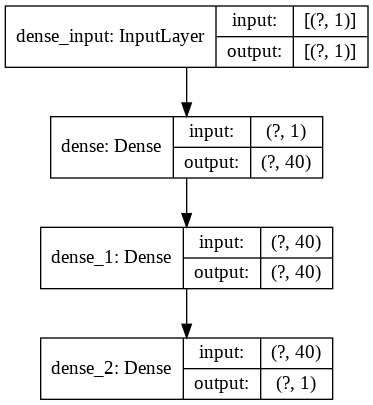

In [0]:
tf.keras.utils.plot_model(model_tmp, show_shapes=True)

## Baseline

### Training
As a baseline to the MAML approach, a network is trained in the usual straightforward approach. The dataset is the same, 9000 tasks (sine waves) with K sample points each.  
Note: I tried with a learning rate of 0.01, which resulted in a network with worse performance - so as always, pay attention to hyper parameters.

#### original baseline

In [0]:
def loss_function(y_true, y_pred):
    """
    Data has batch size: (K, 1)
    Loss is mean squared error/difference across batches
    
    """ 
    # Find squared difference within each batch
    sqr_diff = tf.math.squared_difference(y_true, y_pred)
    # Mean of all squared differences across batches
    mse = tf.reduce_mean(sqr_diff)
    return mse

# def loss_function_dist(y_true, y_pred):
#     sqr_diff = tf.math.squared_difference(y_true, y_pred)
#     return sqr_diff

def compute_loss(model, x, y, loss_fn=loss_function):
    return loss_fn(y, model(x))

# def compute_gradients(model, x, y):
#     with tf.GradientTape() as tape:
#         loss_value = compute_loss(model, x, y)
#     return loss_value, tape.gradient(loss_value, model.trainable_variables)

# def apply_gradients(model, gradients, optimizer):
#     optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    

def train_step(model, x, y, optimizer):
    with tf.GradientTape() as tape:
        # loss_value = loss_function(y, model(x))
        loss_value = compute_loss(model, x, y, loss_fn=loss_function)
    gradients = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))    
    return loss_value

In [0]:
# CHECK MEM RESOURCE USAGE
# import gc
# import resource

# print(f"Step: {i} - loss: {loss} - time spend: {time_spend} sec - {resource.getrusage(resource.RUSAGE_SELF).ru_maxrss}")
# gc.collect()

In [0]:
def baseline_training(model, dataset, K=10, log_step=100, learning_rate=0.001):
    metric_loss = tf.keras.metrics.Mean(name='train_loss')
    
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    total_loss = 0
    losses = []
    start = time.time()
    EPOCHS = 2
    for i, task in dataset.enumerate():
        i = i.numpy()
        xs, ys = task
        x, x_val = xs[:K], xs[K:]
        y, y_val = ys[:K], ys[K:]
        
        train_loss = train_step(model, x, y, optimizer)

        # Logs
        total_loss += train_loss
        loss = total_loss / (i+1.0)
        losses.append(loss)

#         metric_loss(train_loss)

        if i % log_step == 0 and i > 0:
            time_spend = np.around( time.time() - start, 2)
            print(f"step: {i} - loss: {loss} - time spend: {time_spend} sec")
            # print(f"Step: {i} - loss: { metric_loss.result() } - time spend: {time_spend} sec")
            start = time.time()
            
    return losses

#### new - distributed on multiple GPUs

In [0]:
strategy = tf.distribute.MirroredStrategy()
print ('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


In [0]:
BUFFER_SIZE = 9000

BATCH_SIZE_PER_REPLICA = 2
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

EPOCHS = 10

In [0]:
train_val_dist_batched = train_val_ds.batch(GLOBAL_BATCH_SIZE)
train_val_dist = strategy.experimental_distribute_dataset(train_val_dist_batched)

In [0]:
def baseline_training(model, dataset, batch_size=1, K=10, log_step=100, learning_rate=0.001):
    metric_loss = tf.keras.metrics.Mean(name='train_loss')
    
    with strategy.scope():
        optimizer = tf.keras.optimizers.Adam(learning_rate)
        total_loss = 0
        losses = []
        start = time.time()
        EPOCHS = 2
        for i, batch in dataset.enumerate():
            i = i.numpy()
            train_losses = []
            for task in batch:
                x, y, _, _ = get_samples(task)
                train_loss = train_step(model, x, y, optimizer)
                train_losses.append(train_loss)
            # batch_loss = tf.reduce_mean(train_losses)
            batch_loss = tf.reduce_sum(train_losses) * (1.0 / GLOBAL_BATCH_SIZE)


            # Logs
            total_loss += batch_loss
            loss = total_loss / (i+1.0)
            losses.append(loss)

            # metric_loss(train_loss)

            if i % log_step == 0 and i > 0:
                time_spend = np.around( time.time() - start, 2)
                print(f"step: {i} - loss: {loss} - time spend: {time_spend} sec")
                # print(f"Step: {i} - loss: { metric_loss.result() } - time spend: {time_spend} sec")
                start = time.time()
            
    plt.plot(losses)
    plt.show()    


In [0]:
# load model - instead of training
# NOTE: the loaded model will likely have been trained on a different 
# training set, so it is not ensured that the test set is completely unseen

# baseline = create_model()
# baseline.load_weights(path_root + baseline_name)

#### old

step: 100 - loss: 3.77329158782959 - time spend: 0.92 sec
step: 200 - loss: 4.050283908843994 - time spend: 0.9 sec
step: 300 - loss: 4.046684265136719 - time spend: 0.88 sec
step: 400 - loss: 3.9317173957824707 - time spend: 0.86 sec
step: 500 - loss: 3.8136963844299316 - time spend: 0.85 sec
step: 600 - loss: 3.781506299972534 - time spend: 0.85 sec
step: 700 - loss: 3.7828803062438965 - time spend: 0.83 sec
step: 800 - loss: 3.7166998386383057 - time spend: 0.86 sec
step: 900 - loss: 3.7648065090179443 - time spend: 0.88 sec
step: 1000 - loss: 3.746267080307007 - time spend: 0.89 sec
step: 1100 - loss: 3.7066383361816406 - time spend: 0.88 sec
step: 1200 - loss: 3.6793627738952637 - time spend: 0.87 sec
step: 1300 - loss: 3.6738502979278564 - time spend: 0.87 sec
step: 1400 - loss: 3.604524850845337 - time spend: 0.91 sec
step: 1500 - loss: 3.5923218727111816 - time spend: 0.86 sec
step: 1600 - loss: 3.5733914375305176 - time spend: 0.88 sec
step: 1700 - loss: 3.557140588760376 - ti

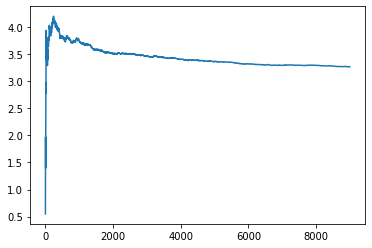

In [0]:
batch_size = 8
train_val_batched = train_val_ds.batch(batch_size, drop_remainder=True)

baseline = create_model()
baseline_train_losses = baseline_training(baseline, train_val_ds, K=10, log_step=100)

In [0]:
# save model
# baseline.save_weights(path_root + baseline_name)

### Testing
The networks ability to adapt to new tasks, with only a few samples from each tasks, is evaluated with {0, 1, 10} gradient updates.  
For each task in the test set, the loss value after 0, 1, 10 gradient updates are saved.

In [0]:
def copy_model(model):
    """ Create a model of the predefined similar architecture 
        and copy the weights 
    """
    model_copy = create_model()
    model_copy.set_weights( model.get_weights() )
    return model_copy

In [0]:
def eval_on_test_set(model, dataset, gradient_updates={0, 1, 10}):
    
    # dict with each update as a key and initialzed with empty list
    losses = {k: [] for k in gradient_updates}
    
    log_step = 10
    
    # In the MAML paper an SGD optimizer is used for evaluation,
    # as opposed to the Adam optimizer for training
    optimizer = tf.optimizers.SGD(learning_rate=0.01)

    start = time.time()
    # for i, task in enumerate(dataset.batch(dataset.size()) ):
    for i, task in dataset.enumerate():
        # x, y = task.sample()
        i = i.numpy()
        xs, ys = task
        x = xs[:K]
        y = ys[:K]
        # print(x, y)
        # raise ValueError("!")
        

        # create a new copy for each task, so we don't change the initial model weights
        model_copy = copy_model(model)
        
        # perform the maximum number of gradient updates
        for update in range(max(gradient_updates)+1):
            test_loss, gradients = compute_gradients(model_copy, x, y)
            apply_gradients(model_copy, gradients, optimizer)

            # save loss if this update is specified
            if update in gradient_updates:
                losses[update].append( test_loss.numpy() )
            
        if i % log_step == 0 and i > 0:
            max_update = max(gradient_updates)
            loss_max_latest = np.around(losses[max_update][-1], 4)
            time_spend = np.around(time.time() - start, 4)
            print( f"Step: {i} - loss_{max_update}: {loss_max_latest} - time spend: {time_spend}" )
            start = time.time()
            
    return losses


In [0]:
baseline_losses = eval_on_test_set(baseline, test_ds)

Step: 10 - loss_10: 0.018200000748038292 - time spend: 1.4527
Step: 20 - loss_10: 0.1996999979019165 - time spend: 1.2684
Step: 30 - loss_10: 0.5796999931335449 - time spend: 1.2993
Step: 40 - loss_10: 3.5160999298095703 - time spend: 1.282
Step: 50 - loss_10: 0.3310000002384186 - time spend: 1.3099
Step: 60 - loss_10: 0.31049999594688416 - time spend: 1.2818
Step: 70 - loss_10: 0.16509999334812164 - time spend: 1.2992
Step: 80 - loss_10: 0.07530000060796738 - time spend: 1.3187
Step: 90 - loss_10: 0.5541999936103821 - time spend: 1.2935
Step: 100 - loss_10: 0.6442000269889832 - time spend: 1.2745
Step: 110 - loss_10: 0.21699999272823334 - time spend: 1.2924
Step: 120 - loss_10: 1.2718000411987305 - time spend: 1.2965
Step: 130 - loss_10: 1.3101999759674072 - time spend: 1.2779
Step: 140 - loss_10: 0.1834000051021576 - time spend: 1.2988
Step: 150 - loss_10: 0.019899999722838402 - time spend: 1.269
Step: 160 - loss_10: 0.3797000050544739 - time spend: 1.3096
Step: 170 - loss_10: 0.7606

### Evaluation
The loss for each of the 1000 tasks in the test set, is reduced to 100 points, by averaging over 10 points for each.  
This is done to simplify the plot and help show trends.  
For each of the averaged 100 points, the loss after 0, 1, 10 gradient updates are plotted.

In [0]:
def plot_losses(losses):
    fig = plt.figure(figsize=(10,5))
    for k in losses:
        loss = losses[k]
        loss_100 = np.asarray(loss).reshape((100,-1))
        loss_mean = np.mean(loss_100, axis=1)
        plt.plot(loss_mean, label=f'After {k} steps')
        
        
    plt.legend()
    plt.title("Loss computed after 0,1,10 gradient updates (mean of 10 data points)")
    plt.xlabel("Test data: each point is the mean of 10 data points")
    plt.ylabel("Loss based on K sample")
    plt.close()
    #plt.show()
    return fig


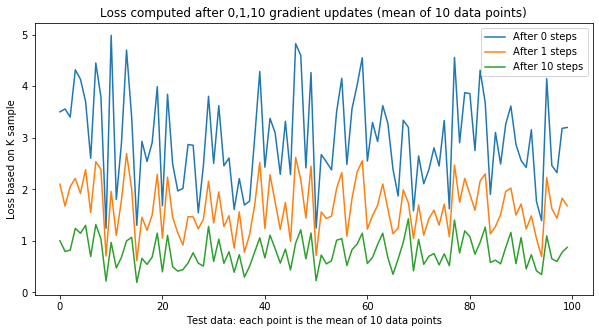

In [0]:
loss_plot = plot_losses(baseline_losses)
loss_plot

Clearly the network adapts to the new tasks and improves with each gradient update. But a high variance remains in each update, indicating that there are some sine waves it has not learned to represent well.

In order to better understand what is going on (and to reproduce the paper results), we can visualize the adaptions.  
By creating random tasks and plotting the sine wave, it's sampled points and the model predictions for the full wave (100 evenly spaced points) after each update.

In [0]:
def visualize_model_adaptation(model, num_plots=3, gradient_updates={0, 1, 10}):
    # In the MAML paper an SGD optimizer is used for evaluation,
    # as opposed to the Adam optimizer for training
    optimizer = tf.optimizers.SGD(learning_rate=0.01)
    
    log_step = 10
    plots = []
    
    for _ in range(num_plots):
        task = TaskGenerator(k_shot=10)
        x, y = task.sample()
        x_full, y_full = task.sample_linspace()

        # copy model, so we don't have to retrain the original after this
        model_copy = copy_model(model)
        
        predictions = {k: [] for k in gradient_updates}
        
        for update in range(0, max(gradient_updates)+1):
            # save prediction
            if update in gradient_updates:
                predictions[update] = model_copy(x_full)
                # y_full_pred = model_copy(x_full)
                # y_full_pred = y_full_pred * 10.0 - 5.0
                # predictions[update] = y_full_pred
            
            # update model
            _, gradients = compute_gradients(model_copy, x, y)
            apply_gradients(model_copy, gradients, optimizer)
            

        fig = plt.figure(figsize=(8,4))
        plt.ylim(-10,5)
        plt.xlim(-5,5)

        plt.plot(x, y, '^', label='K sample points')
        plt.plot(x_full, y_full, '-', label='True sine wave')
        for update in gradient_updates:
            plt.plot(x_full, predictions[update], '--', label=f'After {update} steps')    
        plt.legend(loc='lower left')
        plt.show()
        # plt.close()
        # plots.append(fig)
        
    return plots

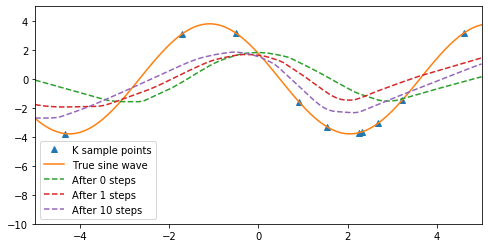

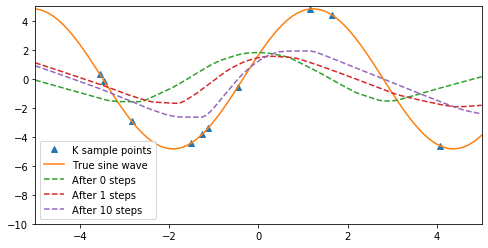

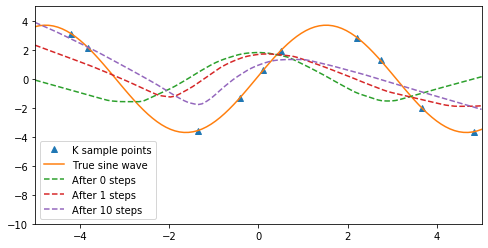

In [0]:
bla = visualize_model_adaptation(baseline)

Running through a few examples, it is clear that sometimes 10 updates improves little on 0 and 1, and some waves are not represented well at all.

## MAML

### Training

###INSERT ALGO 2 FROM PAPER

In [0]:
def apply_gradients_diff(model_copy, model, gradients, learning_rate):
    """
    Apply gradients in a differentable way, so that is can be used when
    calculating second-order derivatives.
    """
    j = 0
    for i in range(len(model_copy.layers)):
        model_copy.layers[i].kernel = tf.subtract(model.layers[i].kernel,
                    tf.multiply(learning_rate, gradients[j]))
        model_copy.layers[i].bias = tf.subtract(model.layers[i].bias,
                    tf.multiply(learning_rate, gradients[j+1]))
        j += 2

#### Experiment with apply gradients

In [0]:
def apply_gradients_diff_2(model_copy, model, gradients, learning_rate):
    """
    Apply gradients in a differentable way, so that is can be used when
    calculating second-order derivatives.
    It does not seem to be possible to use: optimizer.apply_gradients, inside
    a GradientTape context.
    """
    j = 0
    for i in range(len(model_copy.layers)):
        model_copy.layers[i].kernel = tf.subtract(model.layers[i].kernel,
                    tf.multiply(learning_rate, gradients[j]))
        model_copy.layers[i].bias = tf.subtract(model.layers[i].bias,
                    tf.multiply(learning_rate, gradients[j+1]))
        j += 2

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, input_shape=(28,28,1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
flatten (Flatten)            (None, 21632)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                216330    
Total params: 216,650
Trainable params: 216,650
Non-trainable params: 0
_________________________________________________________________


In [0]:
bla = model.layers[0]

In [0]:
bla.weights

[<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
 array([[[[-0.00334549, -0.09807794,  0.105371  ,  0.1259784 ,
           -0.00174218,  0.03478451, -0.03541587,  0.10885142,
           -0.03296513, -0.11356363,  0.02797455,  0.03334768,
            0.00201833,  0.1254114 ,  0.02667259, -0.11525407,
            0.09772538, -0.06118987, -0.10945439,  0.08762152,
            0.09395358, -0.00502203, -0.10928946, -0.0052132 ,
           -0.00649711,  0.00272149, -0.08104036, -0.1289738 ,
            0.05637865, -0.06244238, -0.09810996, -0.05072007]],
 
         [[ 0.05602628, -0.00015274, -0.1279338 , -0.03145836,
           -0.07781154, -0.06619964,  0.07839596,  0.11534078,
            0.04764873, -0.03078892,  0.10316843,  0.06619841,
           -0.12392059, -0.04179004, -0.12255304,  0.13952409,
           -0.09514278,  0.04470842, -0.01640883,  0.13369398,
            0.13668127,  0.04431519, -0.02691973,  0.12409149,
            0.07519317,  0.09292418,  0.

#### original - 1 batch

In [0]:
def maml_training(model, dataset, K=10):
    alpha = 0.01 # training learning rate
    beta = 0.01 # meta learning rate
    log_step = 100 # how often to display training progress
    
    # used in meta step to apply gradients (does not need to be differentiable)
    optimizer = tf.keras.optimizers.Adam(beta)
    optimizer_inner = tf.keras.optimizers.SGD(alpha)

    total_loss = 0
    losses = []
    start = time.time()
    for i, task in enumerate(dataset):
        x, y = task.sample() # sample for inner loop training
        x_meta, y_meta = task.sample() # sample for meta update
        
        # In order to calculate a gradient through a gradient, we need a
        # GradientTape within a GradientTape
        with tf.GradientTape() as meta_tape:
            # calc training loss based on model weights
            with tf.GradientTape() as train_tape:
                train_loss = compute_loss(model, x, y)
            train_gradients = train_tape.gradient(train_loss, model.trainable_variables)
            # Create copy, to hold updates weights.
            # Update weights of copy, in a differentiable way.
            # Meta loss is based on updated weights from copy 
            # and a new sample from the same task
            model_copy = copy_model(model)
            
            # optimizer_inner.apply_gradients(zip(train_gradients, model_copy.trainable_variables))
            apply_gradients_diff(model_copy, model, train_gradients, alpha)
            
            meta_loss = compute_loss(model_copy, x_meta, y_meta)
        # model (not copy) weights are updated based on meta loss
        # meta update does not have to be differentiable
        meta_gradients = meta_tape.gradient(meta_loss, model.trainable_variables)
        optimizer.apply_gradients( zip(meta_gradients, model.trainable_variables) )

        # Logs
        total_loss += meta_loss
        loss = total_loss / (i+1.0)
        losses.append(loss)

        if i % log_step == 0 and i > 0:
            print(f"Step: {i} - loss: {loss} - time spend: {time.time() - start}")
            start = time.time()
    plt.plot(losses)
    plt.show()    
    

#### new - Batch of tasks - lots of maps

In [0]:
def maml_training(model, dataset, steps=100, batch_size=5, log_step=10, first_order=False):
    alpha = 0.01 # training learning rate
    beta = 0.01 # meta learning rate
    
    # used in meta step to apply gradients (does not need to be differentiable)
    optimizer = tf.keras.optimizers.Adam(beta)
    
    total_loss = 0
    losses = []
    
    start = time.time()
    for i in range(steps):
        
        tasks = dataset.batch(batch_size)
        xs_ys = list(map(lambda task: task.sample(), tasks))

        with tf.GradientTape() as t:
            with tf.GradientTape(persistent=True) as t1:
                train_losses = list(map(lambda x_y: compute_loss(model, x_y[0], x_y[1]), xs_ys ) )

            train_gradients = list(map(lambda loss: t1.gradient(loss, model.trainable_variables), train_losses))
            # del t1 # remove link to persistent tape
            model_copies = [create_model()] * len(train_gradients)

            for model_copy, grads in zip(model_copies, train_gradients):
                apply_gradients_diff(model_copy, model, grads, alpha)


            xs_ys_meta = list(map(lambda task: task.sample(), tasks))
            test_losses = []
            for model_copy, (x,y) in zip(model_copies, xs_ys_meta):
                loss = compute_loss(model_copy, x, y)
                test_losses.append(loss)

            batch_loss = tf.reduce_sum(test_losses)

        meta_gradients = t.gradient(batch_loss, model.trainable_variables)
        optimizer.apply_gradients( zip(meta_gradients, model.trainable_variables) )
        # meta_loss = compute_loss(model, x1, y1)

        # Logs
        # total_loss += batch_loss / batch_size
        # loss = total_loss / (i+1.0)
        total_loss += batch_loss / batch_size
        loss = total_loss / (i+1.0)
        losses.append(loss)

        if i % log_step == 0 and i > 0:
            print(f"Step: {i} - loss: {loss} - time spend: {time.time() - start}")
            start = time.time()

    plt.plot(losses)
    plt.show()    


#### new - batch of tasks - compact for loop

In [0]:
def maml_training(model, dataset, steps=100, batch_size=1, log_step=10, first_order=False):
    alpha = 0.01 # training learning rate
    beta = 0.01 # meta learning rate
    
    # used in meta step to apply gradients (does not need to be differentiable)
    optimizer = tf.keras.optimizers.Adam(beta)

    # steps = 3000
    # batch_size = 10
    
    total_loss = 0
    losses = []

    start = time.time()
    for i in range(steps):
        with tf.GradientTape() as meta_tape:
            meta_losses = []
            for task in dataset.batch(batch_size):
                x, y = task.sample() # sample for inner loop training
                
                with tf.GradientTape() as train_tape:
                    train_loss = compute_loss(model, x, y)
                train_gradients = train_tape.gradient(train_loss, model.trainable_variables)
                if first_order:
                    train_gradients = [tf.stop_gradient(grad) for grad in train_gradients]
                model_copy = copy_model(model)
                apply_gradients_diff(model_copy, model, train_gradients, alpha)
                
                x_meta, y_meta = task.sample() # sample for meta update
                meta_loss = compute_loss(model_copy, x_meta, y_meta)
                meta_losses.append(meta_loss)
                
            batch_loss = tf.reduce_sum(meta_losses)
            meta_gradients = meta_tape.gradient(batch_loss, model.trainable_variables)
            optimizer.apply_gradients( zip(meta_gradients, model.trainable_variables) )

        # Logs
        total_loss += batch_loss / batch_size
        loss = total_loss / (i+1.0)
        losses.append(loss)


        if i % log_step == 0 and i > 0:
            print(f"Step: {i} - loss: {loss} - time spend: {time.time() - start}")
            start = time.time()

    return losses

### new - refactored maml training

In [0]:
def apply_gradients_diff(model_copy, model, gradients, learning_rate):
    j = 0
    for i in range(len(model_copy.layers)):
        model_copy.layers[i].kernel = tf.subtract(model.layers[i].kernel,
                    tf.multiply(learning_rate, gradients[j]))
        model_copy.layers[i].bias = tf.subtract(model.layers[i].bias,
                    tf.multiply(learning_rate, gradients[j+1]))
        j += 2

def compute_loss(model, x, y):
    return loss_function(y, model(x))

def inner_loop(model, task, alpha):
    x, y, x_val, y_val = get_samples(task)
    with tf.GradientTape() as train_tape:
        train_loss = compute_loss(model, x, y)
    train_gradients = train_tape.gradient(train_loss, model.trainable_variables)
    
    model_copy = copy_model(model)
    apply_gradients_diff(model_copy, model, train_gradients, alpha)
    meta_loss = compute_loss(model_copy, x_val, y_val)
    return meta_loss
    

def __copy_model(model):
    model_copy = create_model()
    for i, layer in enumerate(model.layers):
        model_copy.layers[i].kernel = layer.kernel
        model_copy.layers[i].bias = layer.bias
    return model_copy

def get_samples(task):
    xs, ys = task
    x, y         = xs[ : K], ys[ : K]
    x_val, y_val = xs[K : ], ys[K : ]
    return x, y, x_val, y_val

def train_step_maml(model, batch, optimizer, K, alpha):
    with tf.GradientTape() as meta_tape:
        meta_losses = []
        for task in batch:
            meta_loss = inner_loop(model, task, alpha)    
            meta_losses.append(meta_loss)
        batch_loss = tf.reduce_sum(meta_losses)
    meta_gradients = meta_tape.gradient(batch_loss, model.trainable_variables)
    optimizer.apply_gradients( zip(meta_gradients, model.trainable_variables) )
    return batch_loss
    

In [0]:
def maml_training(model, dataset, steps=100, batch_size=1, log_step=10, first_order=False):
    alpha = 0.01 # training learning rate
    beta = 0.01 # meta learning rate
    
    # used in meta step to apply gradients (does not need to be differentiable)
    optimizer = tf.keras.optimizers.Adam(beta)

    # steps = 3000
    # batch_size = 10
    
    total_loss = 0
    losses = []
    K = 10

    start = time.time()
    for i, batch in dataset.enumerate():
        i = i.numpy()
        batch_loss = train_step_maml(model, batch, optimizer, K, alpha)
        
        # Logs
        total_loss += batch_loss / batch_size
        loss = total_loss / (i+1.0)
        losses.append(loss)

        if i % log_step == 0 and i > 0:
            print(f"Step: {i} - loss: {loss} - time spend: {time.time() - start}")
            start = time.time()
            
        if i == steps:
            break

    return losses

#### new - adaptation steps

In [0]:
def get_trainable_variables_diff(model):
    variables = []
    for layer in model.layers:
        kernel = layer.kernel
        bias = layer.bias
        variables.append(kernel)
        variables.append(bias)
    return variables

In [0]:
def maml_training(model, dataset, steps=100, batch_size=1, log_step=10, first_order=False):
    alpha = 0.01 # training learning rate
    beta = 0.01 # meta learning rate
    # log_step = 10 # how often to display training progress
    
    # used in meta step to apply gradients (does not need to be differentiable)
    optimizer = tf.keras.optimizers.Adam(beta)

    # steps = 3000
    # batch_size = 10
    
    adaptation_steps = 10
    
    total_loss = 0
    losses = []

    start = time.time()
    for i in range(steps):
        with tf.GradientTape() as meta_tape:
            meta_losses = []
            for task in dataset.batch(batch_size):
                x, y = task.sample() # sample for inner loop training
                
                model_copy = copy_model(model)
                with tf.GradientTape(persistent=True) as train_tape:
                    for j in range(adaptation_steps):
                        train_loss = compute_loss(model_copy, x, y)
                        # train_gradients = train_tape.gradient(train_loss, model_copy.trainable_variables)
                        train_gradients = train_tape.gradient(train_loss, get_trainable_variables_diff(model_copy) )
                        apply_gradients_diff(model_copy, model, train_gradients, alpha)
                
                x_meta, y_meta = task.sample() # sample for meta update
                meta_loss = compute_loss(model_copy, x_meta, y_meta)
                meta_losses.append(meta_loss)
                
            batch_loss = tf.reduce_sum(meta_losses)
            meta_gradients = meta_tape.gradient(batch_loss, model.trainable_variables)
            optimizer.apply_gradients( zip(meta_gradients, model.trainable_variables) )

        # Logs
        total_loss += batch_loss / batch_size
        loss = total_loss / (i+1.0)
        loss = total_loss / len(losses)
        losses.append(loss)

        if i % log_step == 0 and i > 0:
            print(f"Step: {i} - loss: {loss} - time spend: {time.time() - start}")
            start = time.time()

    return losses

#### Load or train model

In [0]:
# load a trained model - instead of training a new
# NOTE: the loaded model will likely have been trained on a different 
# training set, so it is not ensured that the test set is completely unseen

# maml = create_model()
# maml.load_weights(path_root + maml_name)

In [0]:
batch_size = 2
train_val_batched = train_val_ds.batch(batch_size, drop_remainder=True)

maml = create_model()
maml_train_losses = maml_training(maml, train_val_batched, steps=1000, log_step=10, batch_size=batch_size)

Step: 10 - loss: 4.565965175628662 - time spend: 2.0723917484283447
Step: 20 - loss: 3.5072221755981445 - time spend: 1.870072364807129
Step: 30 - loss: 3.5350141525268555 - time spend: 1.8697218894958496
Step: 40 - loss: 3.67116641998291 - time spend: 1.8621923923492432
Step: 50 - loss: 3.933612823486328 - time spend: 1.8521225452423096
Step: 60 - loss: 4.19097900390625 - time spend: 1.8471858501434326
Step: 70 - loss: 4.018211364746094 - time spend: 1.8575093746185303
Step: 80 - loss: 3.826284170150757 - time spend: 1.8947107791900635
Step: 90 - loss: 3.670191526412964 - time spend: 1.9465689659118652
Step: 100 - loss: 3.646277666091919 - time spend: 1.9209868907928467
Step: 110 - loss: 3.5939600467681885 - time spend: 1.8748090267181396
Step: 120 - loss: 3.610844135284424 - time spend: 1.8792238235473633
Step: 130 - loss: 3.5815229415893555 - time spend: 1.902942419052124
Step: 140 - loss: 3.550022602081299 - time spend: 1.8933820724487305
Step: 150 - loss: 3.610055685043335 - time 

In [0]:
# save model
# maml_name = "maml_batch10_regression_weights_K10_9000train.h5"
# maml.save_weights(path_root + maml_name)

### Testing

The model improves significantly after just 1 gradient update. And continues to improve after 10 updates, even though during training, the model was optimized based on only 1 update.

In [0]:
maml_losses = eval_on_test_set(maml, test_ds)

Step: 10 - loss_10: 0.01769999973475933 - time spend: 1.7036
Step: 20 - loss_10: 0.03720000013709068 - time spend: 1.5051
Step: 30 - loss_10: 0.15389999747276306 - time spend: 1.5344
Step: 40 - loss_10: 1.3133000135421753 - time spend: 1.544
Step: 50 - loss_10: 0.3082999885082245 - time spend: 1.541
Step: 60 - loss_10: 0.16750000417232513 - time spend: 1.5169
Step: 70 - loss_10: 0.2159000039100647 - time spend: 1.5286
Step: 80 - loss_10: 0.00559999980032444 - time spend: 1.4659
Step: 90 - loss_10: 0.1477999985218048 - time spend: 1.521
Step: 100 - loss_10: 0.053599998354911804 - time spend: 1.4994
Step: 110 - loss_10: 0.025299999862909317 - time spend: 1.5101
Step: 120 - loss_10: 0.19619999825954437 - time spend: 1.4761
Step: 130 - loss_10: 0.33649998903274536 - time spend: 1.5175
Step: 140 - loss_10: 0.35670000314712524 - time spend: 1.4808
Step: 150 - loss_10: 0.06669999659061432 - time spend: 1.5128
Step: 160 - loss_10: 0.09070000052452087 - time spend: 1.5488
Step: 170 - loss_10: 1

### Evaluation

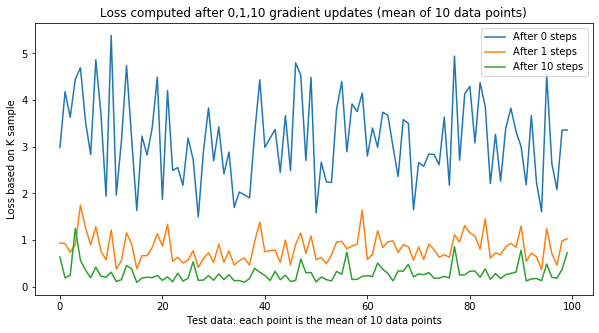

In [0]:
plot_losses(maml_losses)

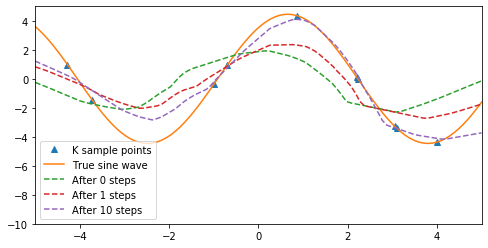

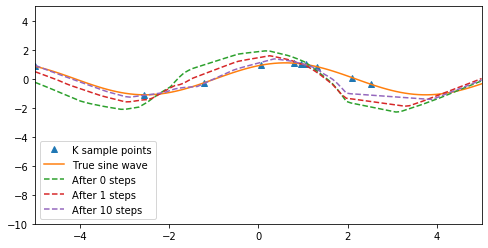

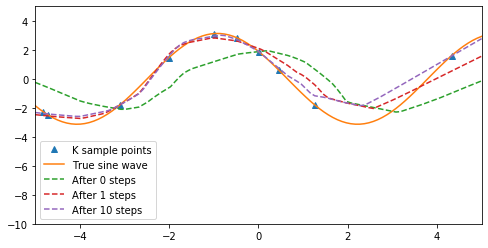

[]

In [0]:
visualize_model_adaptation(maml)